# StrA MS/MS hypothetical structure spectra example notebook

# Notes

Take note of anything you like here. It'll be exported with the notebook when you run the notebook export.

In [1]:
# Imports
import pandas as pd
import numpy as np
import itertools
import glob
import os
import re
import matplotlib.pyplot as plt
import nbconvert

# Import the custom modules
from msms_structure_annot import plotters
from msms_structure_annot import msprocess
from msms_structure_annot import hsmakers
from msms_structure_annot import scoring

In [2]:
# Import relevant paths to use
from msms_structure_annot.paths import data_dir
from msms_structure_annot.paths import reports_dir

## User-specified info

### Experiment / report name

In [3]:
# Specify the name of this notebook (needed to export it in the end)
this_notebook_name = 'StrA_example.ipynb'

# Specify msms files directory in the data_dir folder and load path to them
exp_name = '20210222_stra' # Parent directory name for reports and such
exp_dir = 'example_data/' + exp_name

# Change this if you want to generate different reports; It will currently overwrite any reports currently in there
report_id = 'report001'

exp_data_folder = data_dir / exp_dir
output_folder = reports_dir / exp_name / report_id

print('Data folder:\n', exp_data_folder, '\n')
print('Reports folder:\n', output_folder)

Data folder:
 c:\Users\Dan\Google Drive (dan.the.anderson@gmail.com)\Science\Voigt Lab\Jupyter\MS analyses\structure_elucidation_project\data\example_data\20210222_stra 

Reports folder:
 c:\Users\Dan\Google Drive (dan.the.anderson@gmail.com)\Science\Voigt Lab\Jupyter\MS analyses\structure_elucidation_project\reports\20210222_stra\report001


### Sequence and PTM info

In [4]:
# Original AA sequence
parent_seq = 'GCMSKELEKVLESSSMAKGDGWKVMAKGDGWE' # Will be referred to as one-indexed from here on

# Define N and C-term modifications and their mass shifts
N_term_mod = 1.0078
#C_term_mod = 18.011 # Should normally be 17
C_term_mod = 17.0027
proton_m = 1.0078
# Define number of charges to calculate m/z values for
charges = [1,2,3]

ptm_dict = {
    'name': [
        'rSAM thioether',  # Name of the modification type
    ],
    'm_shift': [  # Mass shift for a given modification
        -1.007, 
    ], 
    'num_mods': [ # Total number of modifications observed
        2, 
    ], 
    'poss_mod_pos': [ # Potential modification positions (one-indexed)
        [18,22,15, 5],
    ],
    'type': [  # Type of modification (ring or point); (ring feature not currently implemented)
        'point',
    ]
}

In [5]:
# This is what multiple PTMs would look like
'''
ptm_dict = {
    'name': [
        'rSAM thioether', 
        'dehydration'
    ],
    'm_shift': [  # Mass shift for a given modification
        -1.007, 
        -16.00
    ], 
    'num_mods': [ # Total number of modifications observed
        2, 
        2
    ], 
    'poss_mod_pos': [ # Potential modification positions (one-indexed)
        [18,22,15],
        [2,5,7] 
    ] 
}
'''

"\nptm_dict = {\n    'name': [\n        'rSAM thioether', \n        'dehydration'\n    ],\n    'm_shift': [  # Mass shift for a given modification\n        -1.007, \n        -16.00\n    ], \n    'num_mods': [ # Total number of modifications observed\n        2, \n        2\n    ], \n    'poss_mod_pos': [ # Potential modification positions (one-indexed)\n        [18,22,15],\n        [2,5,7] \n    ] \n}\n"

### MS spectra processing parameters

In [6]:
## User-specified parameters
tol = 0.05 # mass-deviation tolerance; Default 0.4
sn_thr = 0.1 # signal-to-noise threshold (must be sn_thr times above background for ion to count); Default 5
N = 12800 # Number of sections to split m/z datapoints into when calculating background values; Default 500
upper_lim = 10 # limit to deviance above average ms ion intensity to set ion values to a limit; Default 50

## Importing

### PTMs

In [7]:
# Import PTMs into a dataframe
ptms_df = pd.DataFrame(ptm_dict)
ptms_df.index.name = 'ptm_id'
ptms_df = ptms_df.reset_index()
ptms_df

,ptm_id,name,m_shift,num_mods,poss_mod_pos,type
0,0,rSAM thioether,-1.007,2,"[18, 22, 15, 5]",point


### Mass spec files

In [9]:
ms_df = msprocess.import_ms_files(exp_data_folder)

## Processing mass spectra files

- cap the maximum value of high abundance ions
- calculate background level and filter by signal to noise

In [10]:
# Make sure everything is sorted before running background calculations
ms_df.sort_values(by = ['spec_num', 'm/z'], inplace= True)

# First apply abundance ceiling to each spectra file
ms_df['abund_ceil'] =  ms_df.groupby('spec_num')['orig_abundance'].apply(msprocess.abund_ceiling, upper_lim)
# Then calculate the background signal within each section
ms_df['bkgd'] = ms_df.groupby('spec_num')['abund_ceil'].transform(msprocess.bkgd_calc_ser, N)

In [11]:
ms_df.head()

,m/z,orig_abundance,spec_num,abund_ceil,bkgd
0,183.1453,87.66,1,87.66,114.065000
1,292.0792,140.47,1,140.47,92.390000
2,370.1665,49.04,1,49.04,92.873333
3,489.1979,89.11,1,89.11,60.030000
4,529.2212,41.94,1,41.94,53.033333


In [12]:
# Filter masses based off how far above the background signal they are according to the signal to noise threshold
ms_df_sn_filter = ms_df[ms_df['abund_ceil'] > sn_thr*ms_df['bkgd']].reset_index(drop = True)

## Create all hypothetical structures (hs) and fragment them

In [13]:
# Generate all possible hypothetical structures from provided PTM dataframe
hs_df = hsmakers.gen_hss(ptms_df)
hs_df

,hs_id,ptm_id,ptm_locs
0,0,0,"(18, 22)"
1,1,0,"(18, 15)"
2,2,0,"(18, 5)"
3,3,0,"(22, 15)"
4,4,0,"(22, 5)"
5,5,0,"(15, 5)"


### Fragment and assign masses

In [14]:
frag_df = hsmakers.frag_hs(hs_df, ptms_df, parent_seq, N_term_mod, C_term_mod)
frag_df.head(10)

,hs_id,seq,hyp_mw,ion_name,b_y_p
0,0,G,58.0292,b1,b
1,0,GC,161.0383,b2,b
2,0,GCM,292.0787,b3,b
3,0,GCMS,379.1107,b4,b
4,0,GCMSK,507.2056,b5,b
5,0,GCMSKE,636.2482,b6,b
6,0,GCMSKEL,749.3322,b7,b
7,0,GCMSKELE,878.3748,b8,b
8,0,GCMSKELEK,1006.4697,b9,b
9,0,GCMSKELEKV,1105.5381,b10,b


### Add multiply-charged ions to hypothetical ion dataframe

- Look for multiply-charged ions instead of just single deconvoluted data:
    - which ones to look for:
        - M+H
        - M + 2H / 2
        - M + 3H / 3

In [8]:
frag_df_charged = hsmakers.mk_charge_df(frag_df, charges, proton_m)
frag_df_charged.tail(10)

NameError: name 'frag_df' is not defined

## Scoring hypothetical structures

### Match observed ions to hypothetical ions

In [16]:
matched_df = scoring.match_ions(ms_df_sn_filter, frag_df_charged, tol)
matched_df.head()

,index,hs_id,seq,hyp_mw,ion_name,b_y_p,charge,m/z,orig_abundance,spec_num,abund_ceil,bkgd
0,2,0,GCM,292.0787,$b_{3}$,b,0,292.0792,140.47,1,140.47,92.390000
1,2,0,GCM,292.0787,$b_{3}$,b,0,292.0764,72.29,2,72.29,35.210000
2,2,0,GCM,292.0787,$b_{3}$,b,0,292.0764,29.56,3,29.56,43.416667
3,2,0,GCM,292.0787,$b_{3}$,b,0,292.0710,112.92,4,112.92,84.950000
4,3,0,GCMS,379.1107,$b_{4}$,b,0,379.1014,91.30,2,91.30,34.660000


### Use various scoring metrics to score the hypothetical structures

In [17]:
# Create an empty score dataframe
scores_df = pd.DataFrame({'hs_id': [], 'score': [], 'score_method': []})
scores_df['hs_id'] = scores_df['hs_id'].astype(int)

# Iterate through scoring methods and append scored hypothetical structures
N_spec = len(ms_df['spec_num'].unique()) # calculate the number of ms/ms spectra used

for method in ['frac', 'weights']:
    scores_df = scores_df.append(scoring.score_wrapper(matched_df, frag_df_charged, N_spec, score_method = method))

# Sort it
scores_df = scores_df.sort_values(['score_method', 'score'], ascending = False)
scores_df

,hs_id,score,score_method
0,0,0.000000,weights
1,1,0.000000,weights
2,2,0.000000,weights
3,3,0.000000,weights
4,4,0.000000,weights
5,5,0.000000,weights
2,2,0.058532,frac
4,4,0.058532,frac
0,0,0.057540,frac
5,5,0.056548,frac


## Plots

### Barplots for scored hypothetical structures

In [18]:
import seaborn as sns

#### Plot all metrics

C:\Users\Dan\Anaconda3\envs\msms_structure_annot-env\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


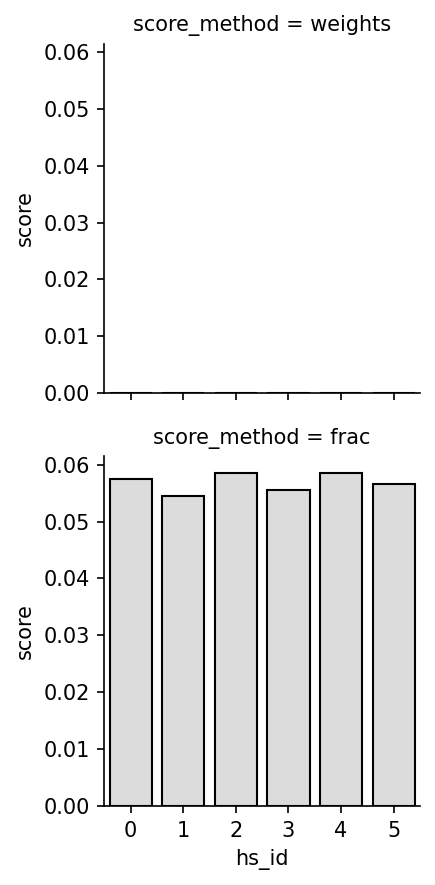

In [19]:
all_scores_fig = sns.FacetGrid(scores_df, row = 'score_method')
all_scores_fig.map(sns.barplot, 'hs_id', 'score', color = 'gainsboro', edgecolor = 'black')

#### Plot just a single metric

In [9]:
## Can also plot with single metric and order it
metric = 'frac'

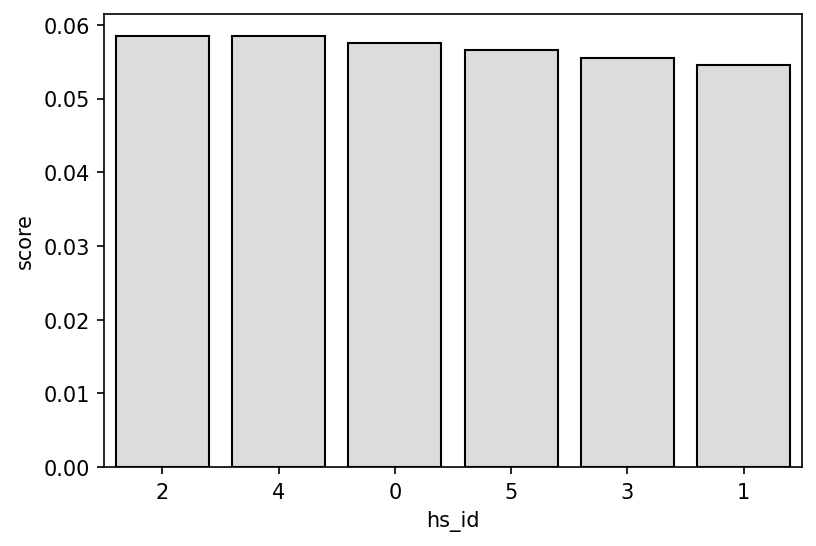

In [20]:

sub_df = scores_df[scores_df['score_method'] == metric]
order = sub_df.sort_values(['score'], ascending = False)['hs_id'].values

single_scores_fig, ax = plt.subplots()
sns.barplot(x = 'hs_id', y = 'score', order = order, data = sub_df,
    color = 'gainsboro', edgecolor = 'black', ax = ax)
plt.show()

### Annotated mass spectra plots

In [21]:
# Pick a single hypothetical structure to plot the matched ions for
hs_id_plot = 2

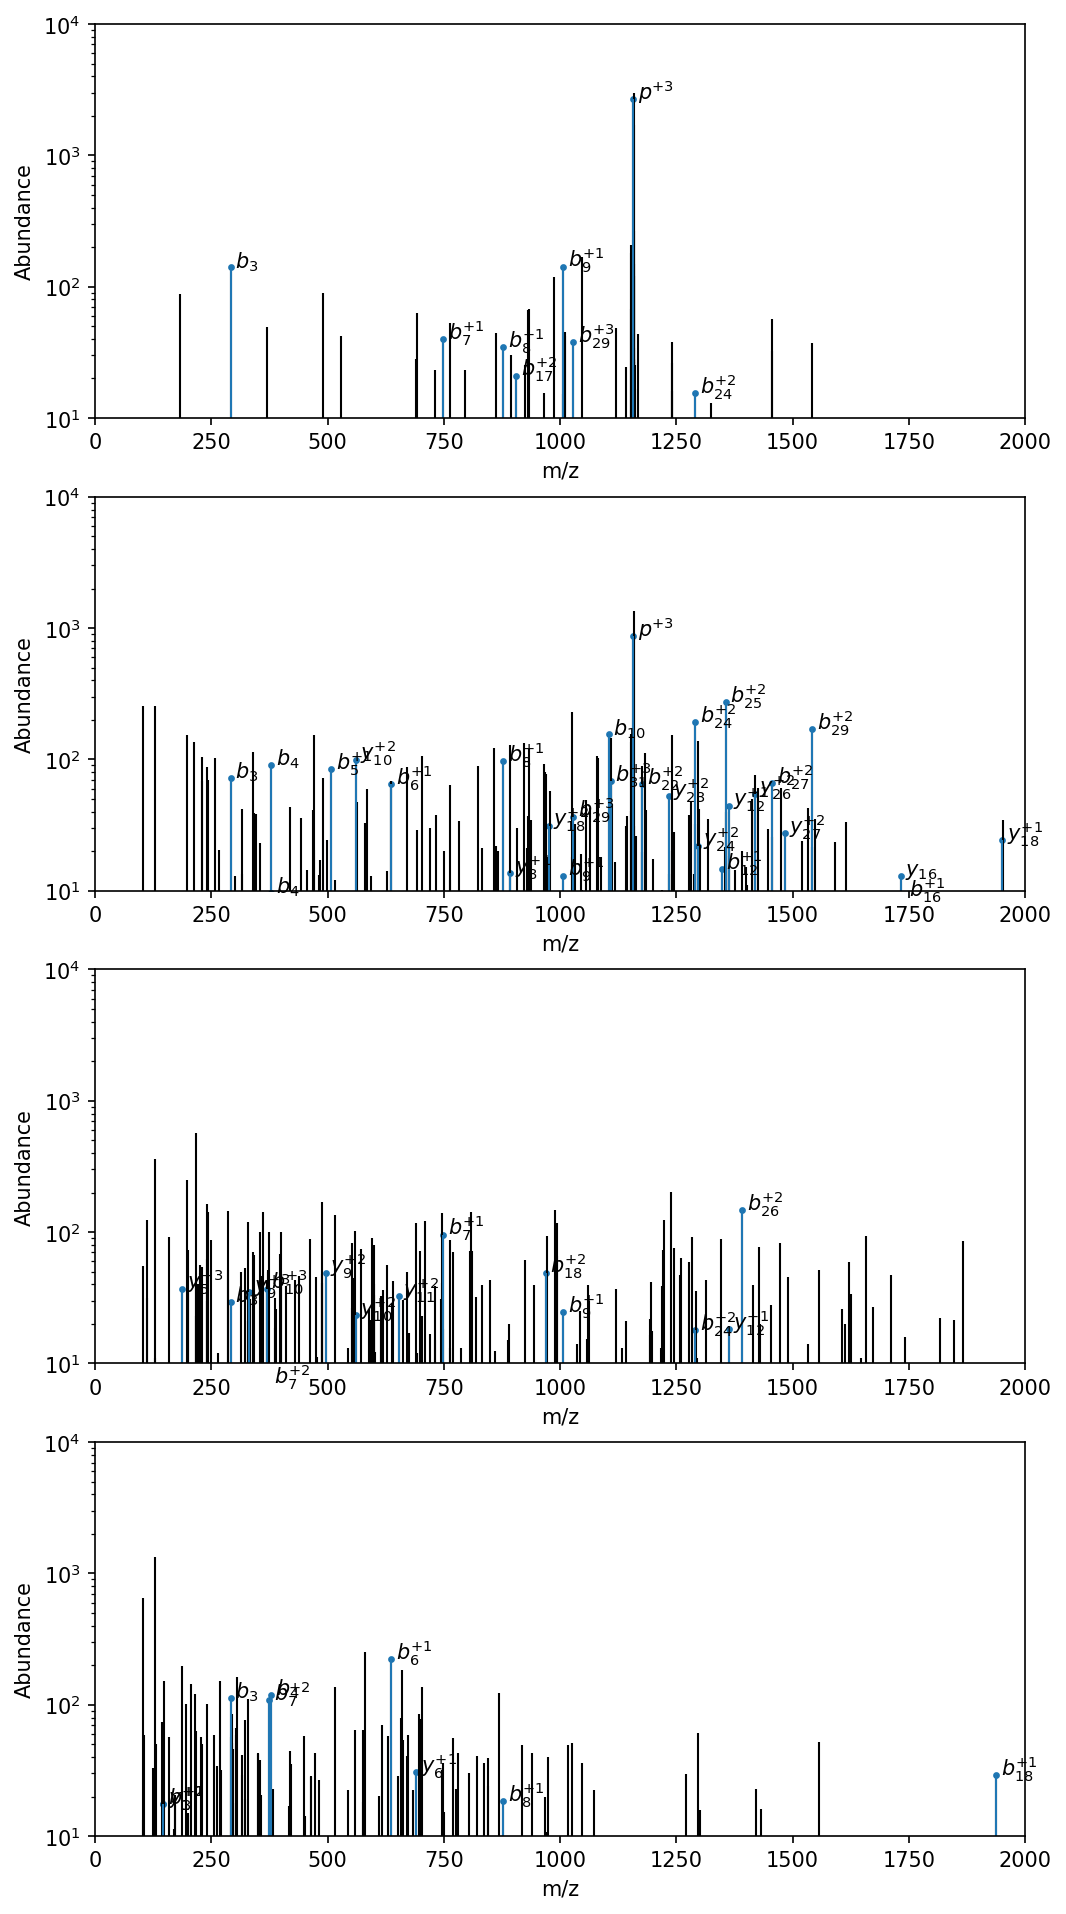

In [22]:
ms_file_nums = ms_df['spec_num'].unique()
spectra_fig, axs = plotters.label_spectra_plot(ms_df, matched_df, ms_file_nums, hs_id = hs_id_plot)
plt.show()

# Exports to reports folder

NOTE: When you're ready to export the reports, it's best practice to rerun all the code cells above before exporting. This makes sure whatever we export down below is in the expected state.

Do this before exporting:
- Rerun all the cells above this point
- Save the Jupyter notebook

In [23]:
## Make output directory if it doesn't already exist
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)

# Output folder specified at the beginning of the notebook
print("Output folder:\n", output_folder)

Output folder:
 c:\Users\Dan\Google Drive (dan.the.anderson@gmail.com)\Science\Voigt Lab\Jupyter\MS analyses\structure_elucidation_project\reports\20210222_stra\report001


### Excel file outputs

In [24]:
# Export matched ions
matched_df.sort_values(['hs_id', 'spec_num', 'm/z'])
matched_df.to_excel(output_folder / 'matched_ions.xlsx', index = False)

# Export sorted score dataframe
scores_df.to_excel(output_folder / 'hs_scores.xlsx', index = False)
# Export hypothetical structures and their PTM locations
hs_df.to_excel(output_folder / 'hs_df.xlsx', index = True)
# Export PTM information
ptms_df.to_excel(output_folder / 'ptms_df.xlsx', index = False)


### Plots

In [25]:
# Make the spectra plots output folder
if not os.path.isdir(output_folder / 'spectra_plots'):
    os.makedirs(output_folder / 'spectra_plots')

In [26]:
all_scores_fig.savefig(output_folder / "all_scores_fig.pdf", dpi=300)
single_scores_fig.savefig(output_folder / "single_score_fig.pdf", dpi=300)
spectra_fig.savefig(output_folder / 'spectra_plots' / 'hs{}_matched_ions.pdf'.format(hs_id_plot), dpi=300)

In [27]:
# If you want to export all the different hs ion matching spectra, iterate over this:
"""
ms_file_nums = ms_df['spec_num'].unique()

for hs_id_plot in hs_df['hs_id'].unique():
    spectra_fig, axs = plotters.label_spectra_plot(ms_df, matched_df, ms_file_nums, hs_id = hs_id_plot)
    spectra_fig.savefig(output_folder / 'spectra_plots' / 'hs{}_matched_ions.pdf'.format(hs_id_plot), dpi=300)
    plt.close(spectra_fig)
"""

"\nms_file_nums = ms_df['spec_num'].unique()\n\nfor hs_id_plot in hs_df['hs_id'].unique():\n    spectra_fig, axs = plotters.label_spectra_plot(ms_df, matched_df, ms_file_nums, hs_id = hs_id_plot)\n    spectra_fig.savefig(output_folder / 'spectra_plots' / 'hs{}_matched_ions.pdf'.format(hs_id_plot), dpi=300)\n    plt.close(spectra_fig)\n"

### The Jupyter notebook itself

Pretty hacky, but you have to put the name of the notebook (done at the top) to be able to export it (very hard to extract programmatically). This will save this notebook as an HTML file so you have a record of what happened.

In [28]:
from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = this_notebook_name
output_file_name = output_folder / str(exp_name + '_' + report_id + '.html')

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)